# CIFAR10 with Inception module - TF2.X

In [27]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.12.0
Python 3.11.2


In [29]:
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.optimizer_v2 import gradient_descent
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing and hyperparameters setup

In [30]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 5
lrate = 0.01
decay = lrate/epochs
data_augmentation = True
num_classes = 10

In [31]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [32]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## Create the inception module

In [10]:
input_img = Input(shape=(32,32,3))

In [33]:
group_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
group_1 = Conv2D(64, (3,3), padding='same', activation='relu')(group_1)
group_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
group_2 = Conv2D(64, (5,5), padding='same', activation='relu')(group_2)
group_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
group_3 = Conv2D(64, (1,1), padding='same', activation='relu')(group_3)

In [34]:
output = concatenate([group_1, group_2, group_3], axis=3)

In [35]:
output = Flatten()(output)
out = Dense(10, activation='softmax')(output)

In [36]:
model = Model(inputs = input_img, outputs= out)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 3)    0           input_1[0][0]                    
____________________________________________________________________________________________

## Setting up the training

In [38]:
sgd = gradient_descent.SGD(lr =lrate, momentum=0.9, decay=decay, nesterov=False)

/Users/apple/Documents/Projects-Python/DeepLearningCode/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:368: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [39]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [40]:
filepath = "/Users/apple/Documents/Projects-Python/DeepLearningCode/src/notebook/computer_vision/cnn/data/inception-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [41]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5, restore_best_weights=True)
callbacks = [checkpoint, early]

In [43]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=30,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.2,
        # set range for random zoom
        zoom_range=0.2,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Using real-time data augmentation.


## Train model

In [44]:
datagen.fit(X_train)
X_train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [45]:
print(f"Number of samples:{X_train_generator.n}")
print(f"Batch size:{X_train_generator.batch_size}")
step_size_train = X_train_generator.n // X_train_generator.batch_size
print(f"Step size train: {step_size_train}")

Number of samples:50000
Batch size:32
Step size train: 1562


In [46]:
history = model.fit(X_train_generator,
                        validation_data=(X_test, y_test),
                        epochs=epochs, verbose=1,
                        steps_per_epoch=step_size_train,
                        callbacks=callbacks)

2024-02-25 10:50:45.114171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/5
1562/1562 [==============================] - 895s 571ms/step - loss: 1.6939 - accuracy: 0.3949 - val_loss: 1.3764 - val_accuracy: 0.5030

Epoch 00001: val_loss improved from inf to 1.37636, saving model to /Users/apple/Documents/Projects-Python/DeepLearningCode/src/notebook/computer_vision/cnn/data/inception-model.h5
Epoch 2/5
1562/1562 [==============================] - 1043s 668ms/step - loss: 1.4879 - accuracy: 0.4673 - val_loss: 1.3756 - val_accuracy: 0.5145

Epoch 00002: val_loss improved from 1.37636 to 1.37564, saving model to /Users/apple/Documents/Projects-Python/DeepLearningCode/src/notebook/computer_vision/cnn/data/inception-model.h5
Epoch 3/5
1562/1562 [==============================] - 1321s 846ms/step - loss: 1.4348 - accuracy: 0.4911 - val_loss: 1.3089 - val_accuracy: 0.5398

Epoch 00003: val_loss improved from 1.37564 to 1.30891, saving model to /Users/apple/Documents/Projects-Python/DeepLearningCode/src/notebook/computer_vision/cnn/data/inception-model.h5
Epo

## Visualizing metrics

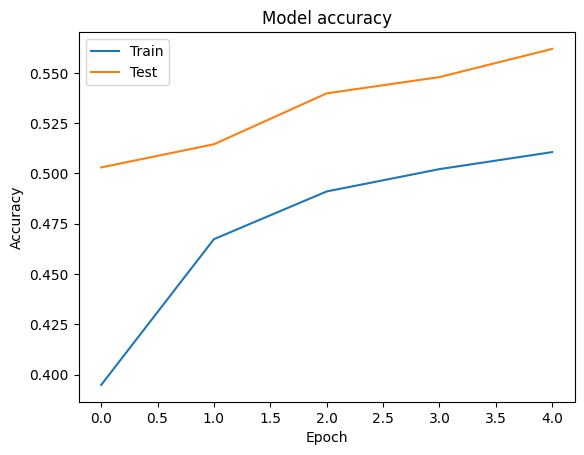

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

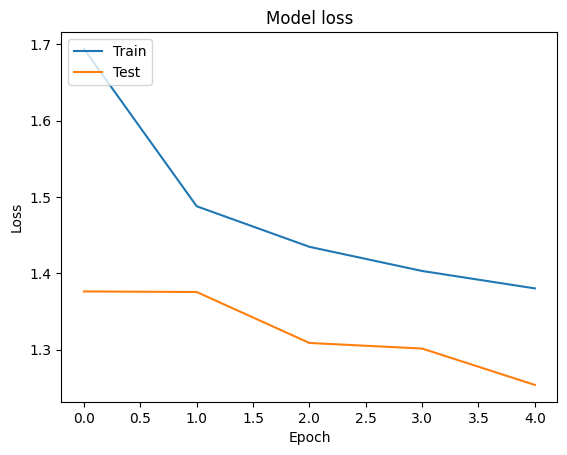

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')